# Initialization

In [45]:
%run utils.ipynb

In [2]:
field_min_x = 0
field_max_x = 15
field_min_y = 0
field_max_y = 10

points0 = [[2,2],
          [2,8],
          [5,1],
          [10,8],
          [1,5],
          [4,8],
          [6,6],
          [10,4],
          [14,6],
          [10,6],
          [12,9]]

points1 = [[2,8],
          [10,8],
          [6,6]]

points2 = [[2,8],
          [10,8],
          [6,2],
          [6,4],
          [6,6]]

points3 = [[1,1],[1,3],[1,5],[1,7],[1,9],
           [3,1],[3,3],[3,5],[3,7],[3,9],
           [5,1],[5,3],[5,5],[5,7],[5,9],
           [7,1],[7,3],[7,5],[7,7],[7,9],
           [9,1],[9,3],[9,5],[9,7],[9,9],
           [11,1],[11,3],[11,5],[11,7],[11,9],
           [13,1],[13,3],[13,5],[13,7],[13,9]]

points4 = [[1,1],
          [1,4],
          [4,1],
          [4,4],
          [2,2],
          [3,2]]

In [3]:
import random
rnd_x = sorted([random.random() * 15 for i in range(50)])
rnd_y = [random.random() * 10 for i in range(50)]
points5 = [[x, y] for x, y in zip(rnd_x, rnd_y)]

# Calculation

In [4]:
stdout_backup = sys.stdout
sys.stdout = StringIO()

In [5]:
#sys.stdout = stdout_backup # print log for get_nearest_intersections()
points = points5

all_lines = points_to_lines(points)
all_intersections = lines_to_intersections(all_lines)
nearest_intersections = get_nearest_intersections(points, all_lines, all_intersections)
segments = get_line_segments(nearest_intersections)

# Results

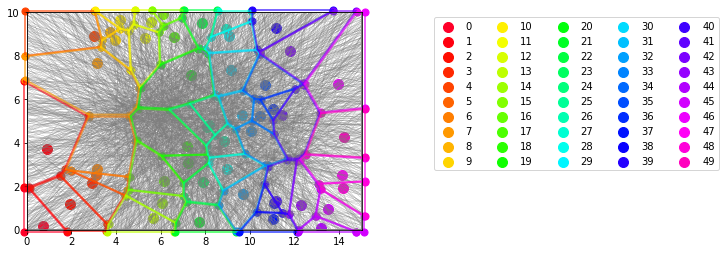

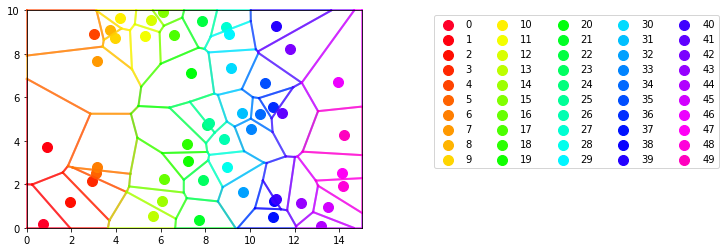

In [46]:
plot(points, all_lines, nearest_intersections, segments)
plot(points, all_lines, nearest_intersections, segments, simple=True)

In [20]:
areas = calculate_areas(nearest_intersections)
areas

,area
0,2.157952
1,8.954893
2,4.419658
3,2.789022
4,6.217205
5,1.132907
6,6.515203
7,11.398692
8,0.617155
9,1.429217
